In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np

In [2]:
args = {"batch_size":64, "test_batch_size":1000, "epochs":5, 
            "lr":1.0, "gamma":0.7, "cuda":False, 
            "mps":True, "dry_run":False, 
            "seed":1, "log_interval":10, "save_model":False}

In [3]:
# Функція для навчання моделі для одного epoch
def train(args, model, device, train_loader, optimizer, epoch):
    # Встановлюємо режим навчання у моделі
    model.train()
    # Список з точністю та значеннями функції втрат
    stats = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # Переміщуємо дані на вказаний пристрій (CPU, CUDA або MPS)
        data, target = data.to(device), target.to(device)
        # Скидаємо градієнти з попередньої ітерації
        optimizer.zero_grad()
        # Обчислюємо передачення
        output = model(data)
        # Функція втрат (логарифмічний максимум правдоподібності)
        loss = F.nll_loss(output, target)
        # Обчислення градієнта втрат відносно параметрів моделі
        loss.backward()
        # Оновлюємо параметри оптимізатора так, щоб мінімізувати втрати
        optimizer.step()
        # Друкуємо статистику кожні log_interval кроків
        if batch_idx % args["log_interval"] == 0:
            accuracy = 100. * batch_idx / len(train_loader)
            print('Train Epoch: {} \t Accuracy: {:.2f}% \t Loss: {:.6f}'.format(epoch, accuracy, loss.item()))
            stats.append([accuracy, loss.item()])
            # Зупиняємо програму, якщо вибрано режим пробного запуску
            if args["dry_run"]:
                break
    return stats

In [4]:
# Функція для оцінки моделі на тестовому наборі даних
def test(model, device, test_loader):
    # Встановити режим оцінки у моделі
    model.eval()
    test_loss = 0
    correct = 0
    # Вимикаємо обчислення градієнта для оцінки
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Обчислюємо суму втрат для пакету
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # Отримуємо індекс передбачення з найбільшою ймовірністю
            pred = output.argmax(dim=1, keepdim=True)
            # Обчислюємо кількість правильних передбачень
            correct += pred.eq(target.view_as(pred)).sum().item()
    # Середні втрати на тестовий зразок
    test_loss /= len(test_loader.dataset)
    # Обчислюємо точність у відсотках
    accuracy = 100. * correct / len(test_loader.dataset)
    # Друкуємо точність та втрати
    print('\nTest set: Accuracy: {:.2f}%, Average loss: {:.4f}\n'.format(accuracy, test_loss))
    return [accuracy, test_loss]

In [5]:
# Функція для завантаження даних та запуску циклів навчання/тестування
def run(model, args):
    # Встановлюємо початкове значення для генерації випадкових чисел на всіх пристроях
    torch.manual_seed(args["seed"])
    # Встановлюємо пристрій для використання (CUDA, MPS або CPU)
    if args["cuda"] and torch.cuda.is_available():
        device = torch.device("cuda")
    elif args["mps"] and torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    # Встановлюємо розміри навчальних та тестових пакетів
    train_kwargs = {'batch_size': args["batch_size"]}
    test_kwargs = {'batch_size': args["test_batch_size"]}
    # Налаштування для CUDA, якщо використовується GPU
    if args["cuda"]:
        cuda_kwargs = {'num_workers': 1,
                        'pin_memory': True,
                        'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    # Визначаємо перетворення даних: конвертувати в тензор та нормувати
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    # Завантажуємо набір даних MNIST
    dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
    dataset2 = datasets.MNIST('../data', train=False, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    # Переміщуємо модель на вибраний пристрій
    model = model.to(device)
    # Ініціалізуємо оптимізатор
    optimizer = optim.Adadelta(model.parameters(), lr=args["lr"])
    # Зменшуємо швидкість навчання (learning rate) кожної групи параметрів на гамму кожні епохи step_size
    scheduler = StepLR(optimizer, step_size=1, gamma=args["gamma"])
    result_train = []
    result_test = []
    # Запускаємо цикл навчання/тестування для кожного epoch
    for epoch in range(1, args["epochs"] + 1):
        stats_train = train(args, model, device, train_loader, optimizer, epoch)
        result_train.append(stats_train)
        stats_test = test(model, device, test_loader)
        result_test.append(stats_test)
        # Оновлення швидкості навчання
        scheduler.step()
    # Зберігаємо навчену модель у файлі
    if args["save_model"]:
        torch.save(model.state_dict(), "mnist_cnn.pt")
    return result_train, result_test

## With dropout

In [63]:
class CNN_with_dropout(nn.Module):
    def __init__(self):
        super(CNN_with_dropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [65]:
result_train_with_dropout, result_test_with_dropout = run(CNN_with_dropout(), args)

Train Epoch: 1 	 Accuracy: 0.00% 	 Loss: 2.286934
Train Epoch: 1 	 Accuracy: 1.07% 	 Loss: 1.352096
Train Epoch: 1 	 Accuracy: 2.13% 	 Loss: 1.197048
Train Epoch: 1 	 Accuracy: 3.20% 	 Loss: 0.543831
Train Epoch: 1 	 Accuracy: 4.26% 	 Loss: 0.471882
Train Epoch: 1 	 Accuracy: 5.33% 	 Loss: 0.318351
Train Epoch: 1 	 Accuracy: 6.40% 	 Loss: 0.186251
Train Epoch: 1 	 Accuracy: 7.46% 	 Loss: 0.222872
Train Epoch: 1 	 Accuracy: 8.53% 	 Loss: 0.509567
Train Epoch: 1 	 Accuracy: 9.59% 	 Loss: 0.165139
Train Epoch: 1 	 Accuracy: 10.66% 	 Loss: 0.521309
Train Epoch: 1 	 Accuracy: 11.73% 	 Loss: 0.265297
Train Epoch: 1 	 Accuracy: 12.79% 	 Loss: 0.221875
Train Epoch: 1 	 Accuracy: 13.86% 	 Loss: 0.118601
Train Epoch: 1 	 Accuracy: 14.93% 	 Loss: 0.217282
Train Epoch: 1 	 Accuracy: 15.99% 	 Loss: 0.156587
Train Epoch: 1 	 Accuracy: 17.06% 	 Loss: 0.215654
Train Epoch: 1 	 Accuracy: 18.12% 	 Loss: 0.251262
Train Epoch: 1 	 Accuracy: 19.19% 	 Loss: 0.577094
Train Epoch: 1 	 Accuracy: 20.26% 	 Loss:

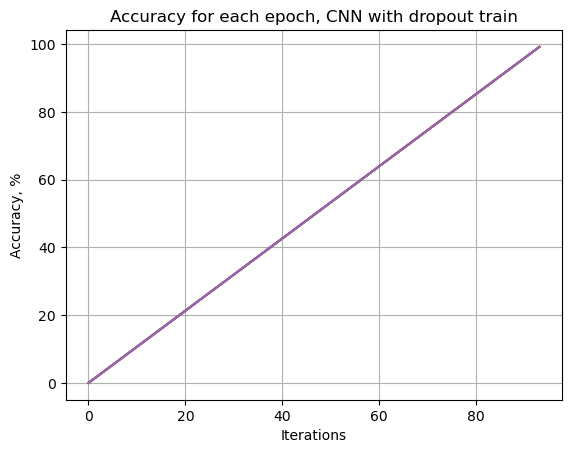

In [66]:
for i in range(len(result_train_with_dropout)):
    acc = [j[0] for j in result_train_with_dropout[i]]
    plt.plot([j for j in range(len(acc))], acc)
plt.title("Accuracy for each epoch, CNN with dropout train")
plt.xlabel("Iterations")
plt.ylabel("Accuracy, %")
plt.grid()
plt.show()

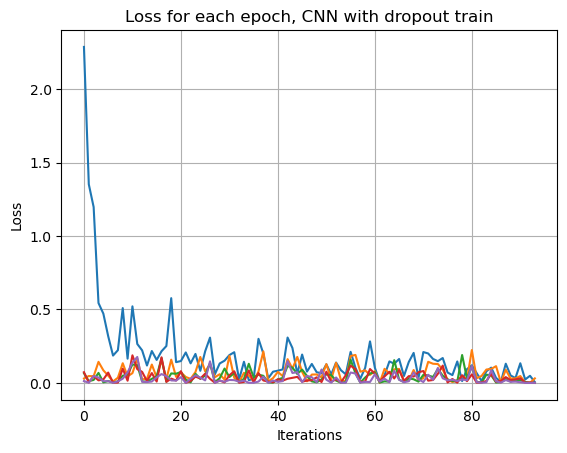

In [67]:
for i in range(len(result_train_with_dropout)):
    loss = [j[1] for j in result_train_with_dropout[i]]
    plt.plot([j for j in range(len(loss))], loss)
plt.title("Loss for each epoch, CNN with dropout train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.show()

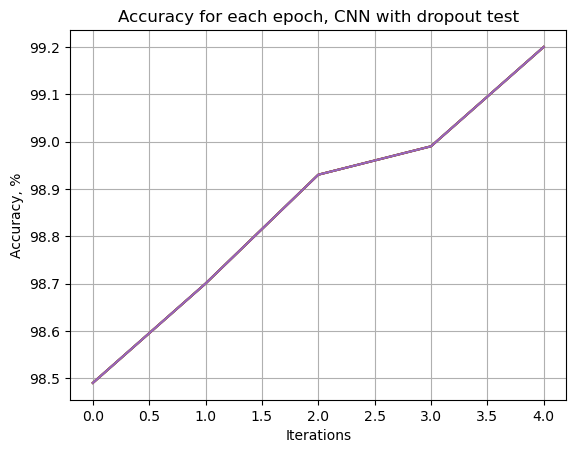

In [118]:
for i in range(len(result_test_with_dropout)):
    acc = [i[0] for i in result_test_with_dropout]
    plt.plot([j for j in range(len(acc))], acc)
plt.title("Accuracy for each epoch, CNN with dropout test")
plt.xlabel("Iterations")
plt.ylabel("Accuracy, %")
plt.grid()
plt.show()

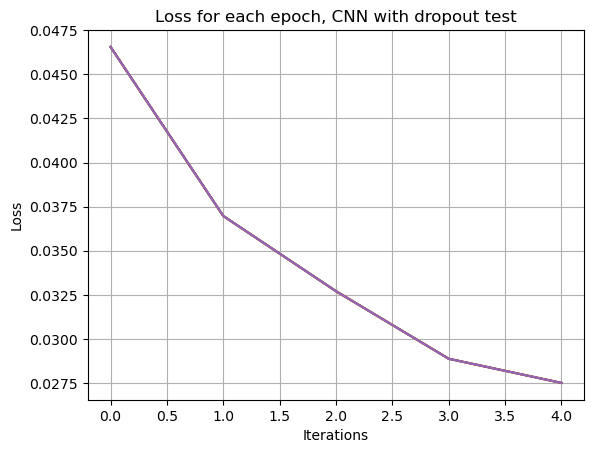

In [120]:
for i in range(len(result_test_with_dropout)):
    loss = [i[1] for i in result_test_with_dropout]
    plt.plot([j for j in range(len(loss))], loss)
plt.title("Loss for each epoch, CNN with dropout test")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.show()

## With another activation function

In [76]:
class CNN_with_GELU(nn.Module):
    def __init__(self):
        super(CNN_with_GELU, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.gelu(x)
        x = self.conv2(x)
        x = F.gelu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [78]:
result_train_with_GELU, result_test_with_GELU = run(CNN_with_GELU(), args)

Train Epoch: 1 	 Accuracy: 0.00% 	 Loss: 2.308844
Train Epoch: 1 	 Accuracy: 1.07% 	 Loss: 0.557545
Train Epoch: 1 	 Accuracy: 2.13% 	 Loss: 0.330979
Train Epoch: 1 	 Accuracy: 3.20% 	 Loss: 0.238058
Train Epoch: 1 	 Accuracy: 4.26% 	 Loss: 0.191221
Train Epoch: 1 	 Accuracy: 5.33% 	 Loss: 0.170892
Train Epoch: 1 	 Accuracy: 6.40% 	 Loss: 0.187680
Train Epoch: 1 	 Accuracy: 7.46% 	 Loss: 0.197543
Train Epoch: 1 	 Accuracy: 8.53% 	 Loss: 0.230760
Train Epoch: 1 	 Accuracy: 9.59% 	 Loss: 0.095148
Train Epoch: 1 	 Accuracy: 10.66% 	 Loss: 0.133372
Train Epoch: 1 	 Accuracy: 11.73% 	 Loss: 0.207903
Train Epoch: 1 	 Accuracy: 12.79% 	 Loss: 0.096336
Train Epoch: 1 	 Accuracy: 13.86% 	 Loss: 0.049081
Train Epoch: 1 	 Accuracy: 14.93% 	 Loss: 0.147729
Train Epoch: 1 	 Accuracy: 15.99% 	 Loss: 0.043252
Train Epoch: 1 	 Accuracy: 17.06% 	 Loss: 0.154167
Train Epoch: 1 	 Accuracy: 18.12% 	 Loss: 0.088532
Train Epoch: 1 	 Accuracy: 19.19% 	 Loss: 0.221058
Train Epoch: 1 	 Accuracy: 20.26% 	 Loss:

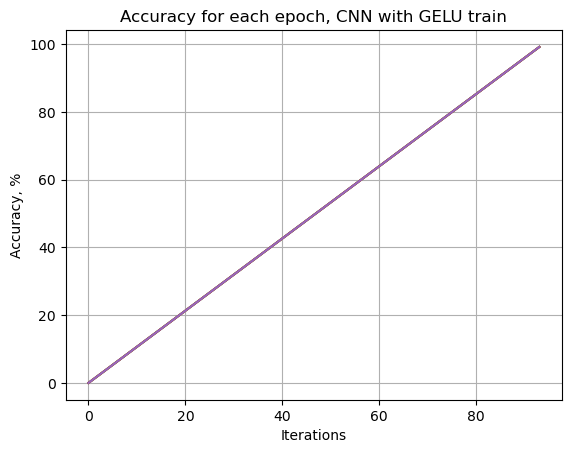

In [87]:
for i in range(len(result_train_with_GELU)):
    acc = [j[0] for j in result_train_with_GELU[i]]
    plt.plot([j for j in range(len(acc))], acc)
plt.title("Accuracy for each epoch, CNN with GELU train")
plt.xlabel("Iterations")
plt.ylabel("Accuracy, %")
plt.grid()
plt.show()

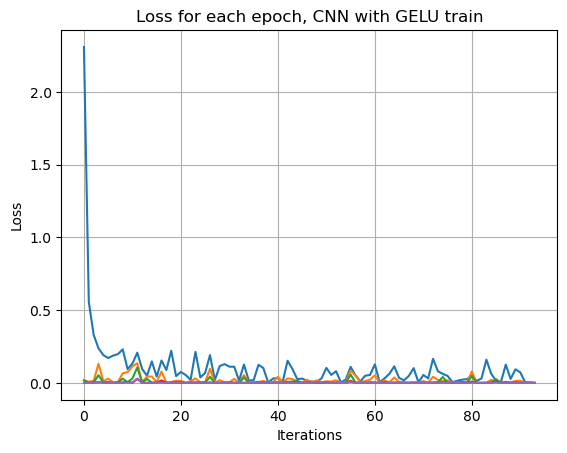

In [90]:
for i in range(len(result_train_with_GELU)):
    loss = [j[1] for j in result_train_with_GELU[i]]
    plt.plot([j for j in range(len(loss))], loss)
plt.title("Loss for each epoch, CNN with GELU train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.show()

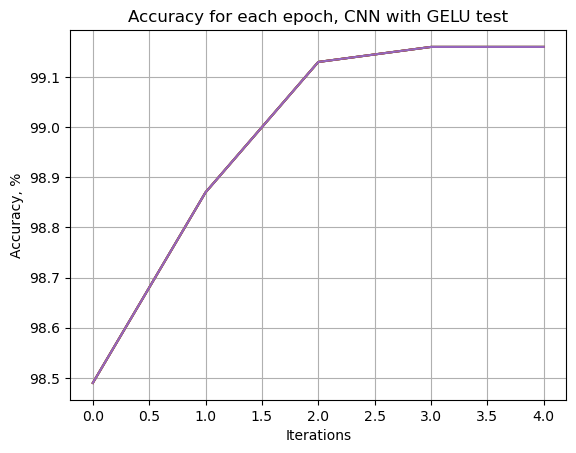

In [114]:
for i in range(len(result_test_with_GELU)):
    acc = [i[0] for i in result_test_with_GELU]
    plt.plot([j for j in range(len(acc))], acc)
plt.title("Accuracy for each epoch, CNN with GELU test")
plt.xlabel("Iterations")
plt.ylabel("Accuracy, %")
plt.grid()
plt.show()

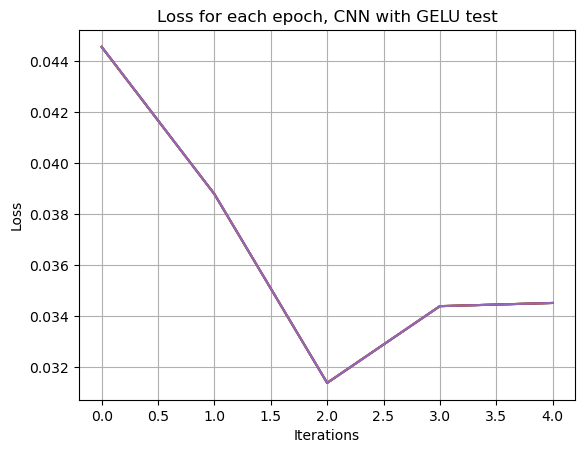

In [116]:
for i in range(len(result_test_with_GELU)):
    loss = [i[1] for i in result_test_with_GELU]
    plt.plot([j for j in range(len(loss))], loss)
plt.title("Loss for each epoch, CNN with GELU test")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.show()

## With additional layer

In [259]:
class CNN_more_layers(nn.Module):
    def __init__(self):
        super(CNN_more_layers, self).__init__()
        self.fc1 = nn.Linear(128 * 11 * 11, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 10)
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [260]:
result_train_with_more_layers, result_test_with_more_layers = run(CNN_more_layers(), args)

Train Epoch: 1 	 Accuracy: 0.00% 	 Loss: 2.312362
Train Epoch: 1 	 Accuracy: 1.07% 	 Loss: 2.006221
Train Epoch: 1 	 Accuracy: 2.13% 	 Loss: 2.041206
Train Epoch: 1 	 Accuracy: 3.20% 	 Loss: 0.795586
Train Epoch: 1 	 Accuracy: 4.26% 	 Loss: 0.403182
Train Epoch: 1 	 Accuracy: 5.33% 	 Loss: 0.551003
Train Epoch: 1 	 Accuracy: 6.40% 	 Loss: 0.186500
Train Epoch: 1 	 Accuracy: 7.46% 	 Loss: 0.309262
Train Epoch: 1 	 Accuracy: 8.53% 	 Loss: 0.377172
Train Epoch: 1 	 Accuracy: 9.59% 	 Loss: 0.338604
Train Epoch: 1 	 Accuracy: 10.66% 	 Loss: 0.108521
Train Epoch: 1 	 Accuracy: 11.73% 	 Loss: 0.211610
Train Epoch: 1 	 Accuracy: 12.79% 	 Loss: 0.159672
Train Epoch: 1 	 Accuracy: 13.86% 	 Loss: 0.140976
Train Epoch: 1 	 Accuracy: 14.93% 	 Loss: 0.142746
Train Epoch: 1 	 Accuracy: 15.99% 	 Loss: 0.065301
Train Epoch: 1 	 Accuracy: 17.06% 	 Loss: 0.221742
Train Epoch: 1 	 Accuracy: 18.12% 	 Loss: 0.088049
Train Epoch: 1 	 Accuracy: 19.19% 	 Loss: 0.384673
Train Epoch: 1 	 Accuracy: 20.26% 	 Loss:

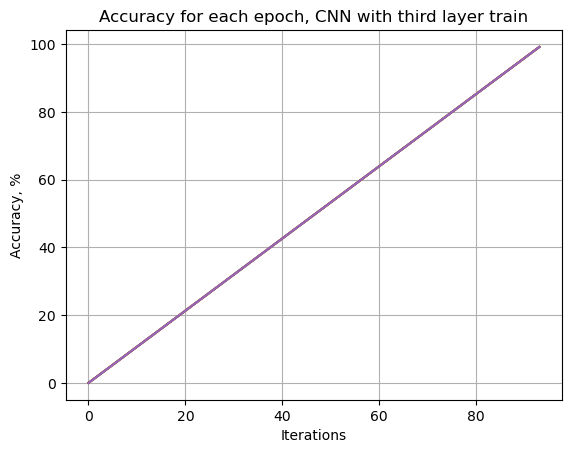

In [241]:
for i in range(len(result_train_with_more_layers)):
    acc = [j[0] for j in result_train_with_more_layers[i]]
    plt.plot([j for j in range(len(acc))], acc)
plt.title("Accuracy for each epoch, CNN with third layer train")
plt.xlabel("Iterations")
plt.ylabel("Accuracy, %")
plt.grid()
plt.show()

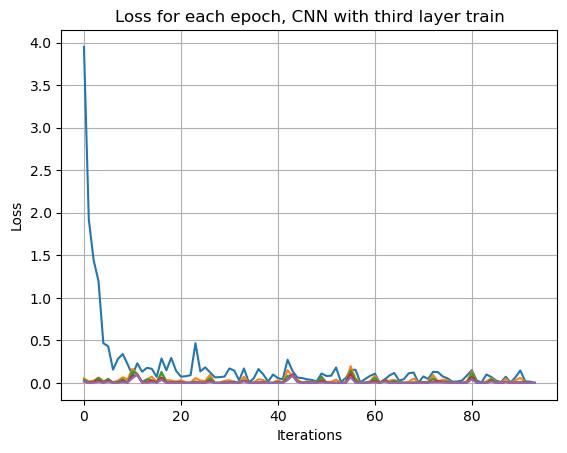

In [243]:
for i in range(len(result_train_with_more_layers)):
    loss = [j[1] for j in result_train_with_more_layers[i]]
    plt.plot([j for j in range(len(loss))], loss)
plt.title("Loss for each epoch, CNN with third layer train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.show()

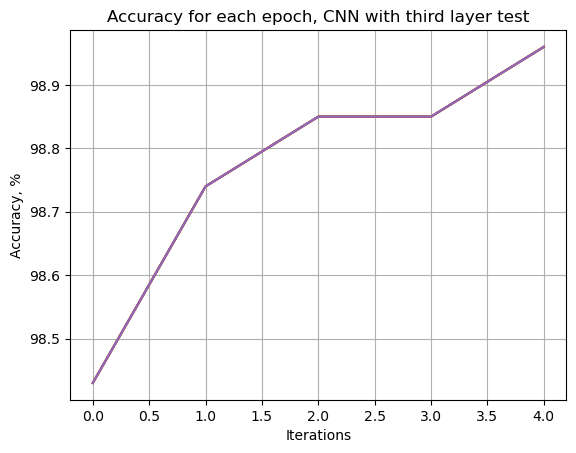

In [237]:
for i in range(len(result_test_with_more_layers)):
    acc = [i[0] for i in result_test_with_more_layers]
    plt.plot([j for j in range(len(acc))], acc)
plt.title("Accuracy for each epoch, CNN with third layer test")
plt.xlabel("Iterations")
plt.ylabel("Accuracy, %")
plt.grid()
plt.show()

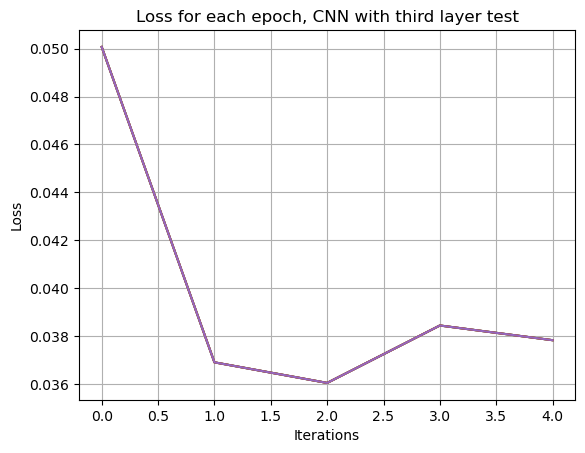

In [239]:
for i in range(len(result_test_with_more_layers)):
    loss = [i[1] for i in result_test_with_more_layers]
    plt.plot([j for j in range(len(loss))], loss)
plt.title("Loss for each epoch, CNN with third layer test")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.show()

## With additional arguments

In [256]:
class CNN_with_conv_attributes(nn.Module):
    def __init__(self):
        super(CNN_with_conv_attributes, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding = 1, dilation = 2, bias = False, padding_mode = 'reflect')
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding = 1, dilation = 2, bias = False, padding_mode = 'reflect')
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [258]:
result_train_with_parametres, result_test_with_parametres = run(CNN_with_conv_attributes(), args)

Train Epoch: 1 	 Accuracy: 0.00% 	 Loss: 2.294246
Train Epoch: 1 	 Accuracy: 1.07% 	 Loss: 1.251716
Train Epoch: 1 	 Accuracy: 2.13% 	 Loss: 0.467123
Train Epoch: 1 	 Accuracy: 3.20% 	 Loss: 0.429637
Train Epoch: 1 	 Accuracy: 4.26% 	 Loss: 0.232788
Train Epoch: 1 	 Accuracy: 5.33% 	 Loss: 0.178766
Train Epoch: 1 	 Accuracy: 6.40% 	 Loss: 0.186968
Train Epoch: 1 	 Accuracy: 7.46% 	 Loss: 0.290332
Train Epoch: 1 	 Accuracy: 8.53% 	 Loss: 0.274671
Train Epoch: 1 	 Accuracy: 9.59% 	 Loss: 0.143639
Train Epoch: 1 	 Accuracy: 10.66% 	 Loss: 0.138521
Train Epoch: 1 	 Accuracy: 11.73% 	 Loss: 0.191317
Train Epoch: 1 	 Accuracy: 12.79% 	 Loss: 0.137354
Train Epoch: 1 	 Accuracy: 13.86% 	 Loss: 0.052024
Train Epoch: 1 	 Accuracy: 14.93% 	 Loss: 0.166844
Train Epoch: 1 	 Accuracy: 15.99% 	 Loss: 0.083731
Train Epoch: 1 	 Accuracy: 17.06% 	 Loss: 0.169465
Train Epoch: 1 	 Accuracy: 18.12% 	 Loss: 0.142450
Train Epoch: 1 	 Accuracy: 19.19% 	 Loss: 0.207815
Train Epoch: 1 	 Accuracy: 20.26% 	 Loss:

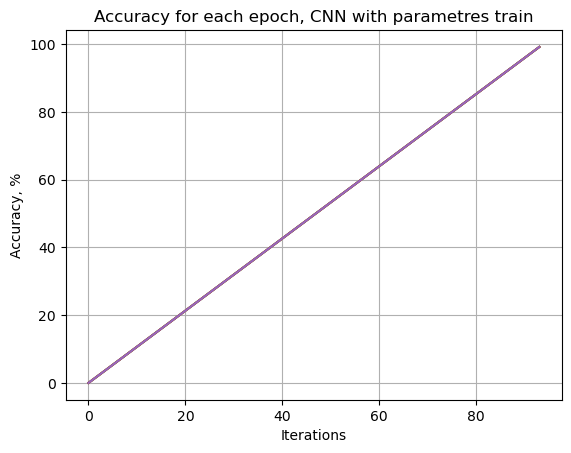

In [263]:
for i in range(len(result_train_with_parametres)):
    acc = [j[0] for j in result_train_with_parametres[i]]
    plt.plot([j for j in range(len(acc))], acc)
plt.title("Accuracy for each epoch, CNN with parametres train")
plt.xlabel("Iterations")
plt.ylabel("Accuracy, %")
plt.grid()
plt.show()

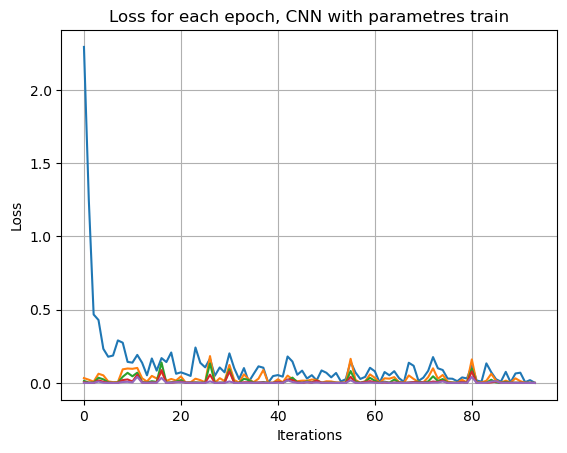

In [264]:
for i in range(len(result_train_with_parametres)):
    loss = [j[1] for j in result_train_with_parametres[i]]
    plt.plot([j for j in range(len(loss))], loss)
plt.title("Loss for each epoch, CNN with parametres train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.show()

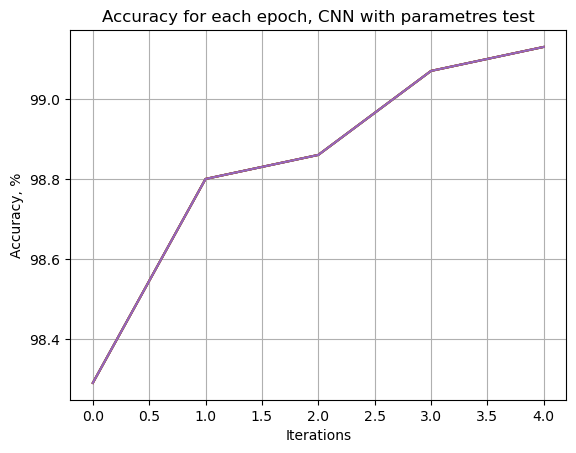

In [265]:
for i in range(len(result_test_with_parametres)):
    acc = [i[0] for i in result_test_with_parametres]
    plt.plot([j for j in range(len(acc))], acc)
plt.title("Accuracy for each epoch, CNN with parametres test")
plt.xlabel("Iterations")
plt.ylabel("Accuracy, %")
plt.grid()
plt.show()

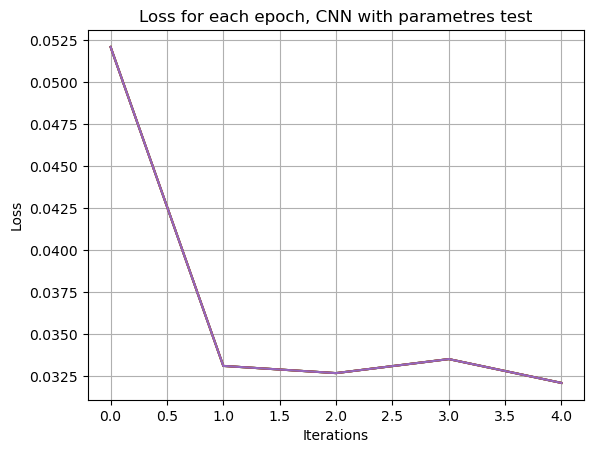

In [266]:
for i in range(len(result_test_with_parametres)):
    loss = [i[1] for i in result_test_with_parametres]
    plt.plot([j for j in range(len(loss))], loss)
plt.title("Loss for each epoch, CNN with parametres test")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.show()

## Всі методи разом:

In [278]:
class CNN_all_combined(nn.Module):
    def __init__(self):
        super(CNN_all_combined, self).__init__()
        self.fc1 = nn.Linear(128 * 11 * 11, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 10)
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding = 1, dilation = 2, bias = False, padding_mode = 'reflect')
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding = 1, dilation = 2, bias = False, padding_mode = 'reflect')
        self.conv3 = nn.Conv2d(64, 128, 3, 1, padding = 1, dilation = 2, bias = False, padding_mode = 'reflect')
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = F.gelu(x)
        x = self.conv2(x)
        x = F.gelu(x)
        x = self.conv3(x)
        x = F.gelu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.gelu(x)
        x = self.dropout3(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [280]:
result_train_all_combined, result_test_all_combined = run(CNN_all_combined(), args)

Train Epoch: 1 	 Accuracy: 0.00% 	 Loss: 2.310144
Train Epoch: 1 	 Accuracy: 1.07% 	 Loss: 2.176736
Train Epoch: 1 	 Accuracy: 2.13% 	 Loss: 1.292811
Train Epoch: 1 	 Accuracy: 3.20% 	 Loss: 0.954202
Train Epoch: 1 	 Accuracy: 4.26% 	 Loss: 0.727408
Train Epoch: 1 	 Accuracy: 5.33% 	 Loss: 0.540083
Train Epoch: 1 	 Accuracy: 6.40% 	 Loss: 0.320001
Train Epoch: 1 	 Accuracy: 7.46% 	 Loss: 0.481861
Train Epoch: 1 	 Accuracy: 8.53% 	 Loss: 0.616223
Train Epoch: 1 	 Accuracy: 9.59% 	 Loss: 0.344327
Train Epoch: 1 	 Accuracy: 10.66% 	 Loss: 0.445264
Train Epoch: 1 	 Accuracy: 11.73% 	 Loss: 0.669755
Train Epoch: 1 	 Accuracy: 12.79% 	 Loss: 0.270206
Train Epoch: 1 	 Accuracy: 13.86% 	 Loss: 0.161953
Train Epoch: 1 	 Accuracy: 14.93% 	 Loss: 0.288779
Train Epoch: 1 	 Accuracy: 15.99% 	 Loss: 0.338382
Train Epoch: 1 	 Accuracy: 17.06% 	 Loss: 0.477203
Train Epoch: 1 	 Accuracy: 18.12% 	 Loss: 0.355223
Train Epoch: 1 	 Accuracy: 19.19% 	 Loss: 0.650981
Train Epoch: 1 	 Accuracy: 20.26% 	 Loss:

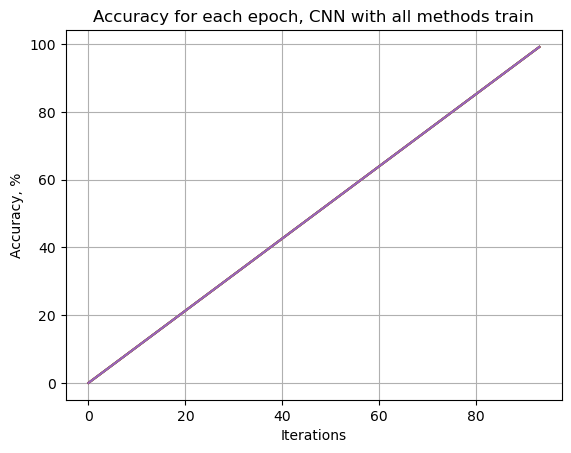

In [282]:
for i in range(len(result_train_all_combined)):
    acc = [j[0] for j in result_train_all_combined[i]]
    plt.plot([j for j in range(len(acc))], acc)
plt.title("Accuracy for each epoch, CNN with all methods train")
plt.xlabel("Iterations")
plt.ylabel("Accuracy, %")
plt.grid()
plt.show()

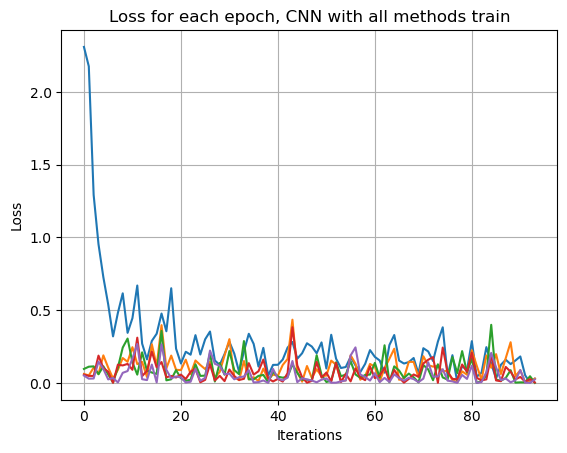

In [284]:
for i in range(len(result_train_all_combined)):
    loss = [j[1] for j in result_train_all_combined[i]]
    plt.plot([j for j in range(len(loss))], loss)
plt.title("Loss for each epoch, CNN with all methods train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.show()

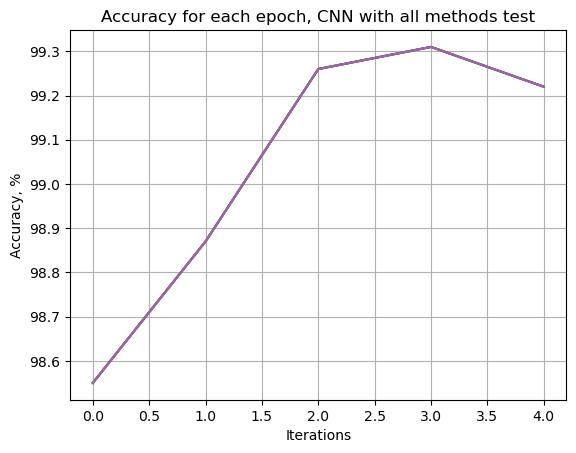

In [286]:
for i in range(len(result_test_all_combined)):
    acc = [i[0] for i in result_test_all_combined]
    plt.plot([j for j in range(len(acc))], acc)
plt.title("Accuracy for each epoch, CNN with all methods test")
plt.xlabel("Iterations")
plt.ylabel("Accuracy, %")
plt.grid()
plt.show()

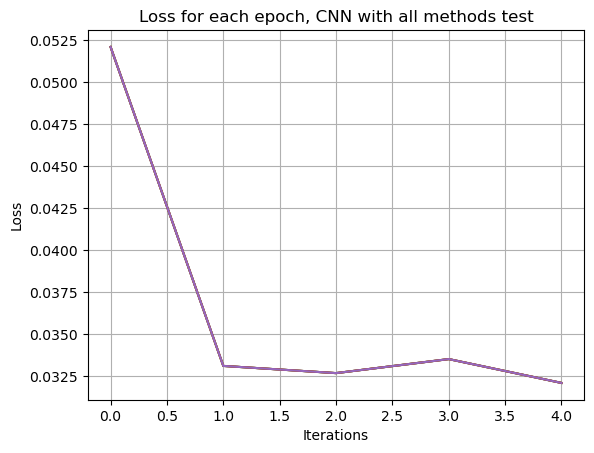

In [324]:
for i in range(len(result_test_with_parametres)):
    loss = [i[1] for i in result_test_with_parametres]
    plt.plot([j for j in range(len(loss))], loss)
plt.title("Loss for each epoch, CNN with all methods test")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.show()

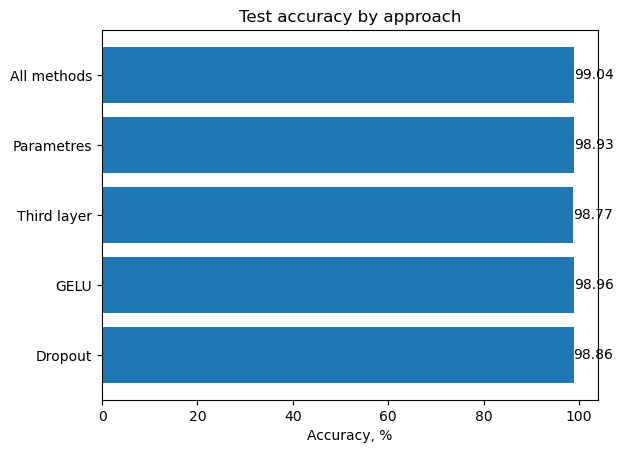

In [9]:
fig, ax = plt.subplots()
accs = [98.862, 98.96199999999999, 98.76599999999999, 98.92800000000001, 99.042]
hbars = ax.barh([k for k in range(len(accs))], accs, align='center')
ax.set_title('Test accuracy by approach')
ax.set_xlabel('Accuracy, %')
ax.set_yticks([k for k in range(len(accs))], labels = ["Dropout", "GELU", "Third layer", "Parametres", "All methods"])
ax.bar_label(hbars, fmt='%.2f')
plt.show()

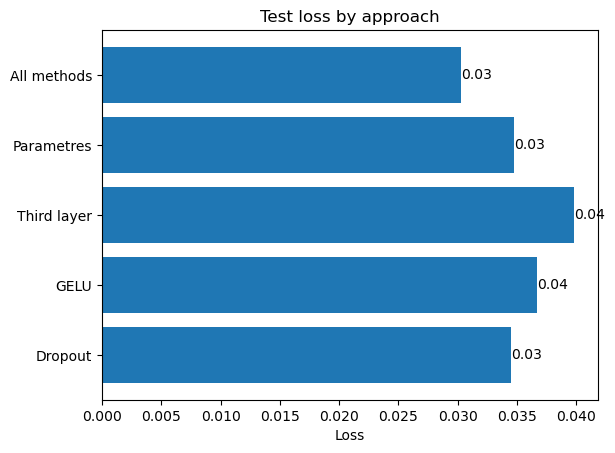

In [13]:
fig, ax = plt.subplots()
losss = [0.03452162793397903, 0.03672719103932381, 0.039863134293556216, 0.03477829926222563, 0.030309799999999998]
hbars = ax.barh([k for k in range(len(losss))], losss, align='center')
ax.set_title('Test loss by approach')
ax.set_xlabel('Loss')
ax.set_yticks([k for k in range(len(losss))], labels = ["Dropout", "GELU", "Third layer", "Parametres", "All methods"])
ax.bar_label(hbars, fmt='%.2f')
plt.show()